# Bibliotecas 


In [1]:
import pandas as pd
import numpy as np
#import networkx as nx
import matplotlib.pyplot as plt
#import re
#from skimage.draw import line
from scipy.spatial import KDTree
import networkx as nx

%load_ext autoreload
%autoreload 2

#Biblioteca de autoria propria
import neuronDynamics as nd

ModuleNotFoundError: No module named 'networkx'

# Funções

### read_swc()

In [2]:
# Funcao para ler o arquivo SWC
def read_swc(arquivo):
    
    df = pd.read_csv(arquivo, header=None)
    colunas = ['knot','tipo','x', 'y','z', 'raio','pai']
    remove = []
    for i, row in df.iterrows():
        linha = row[0].split()
        if linha[0] == '#' or linha[0] == '#The':
            remove.append(i)
        if linha[0] == 1:
            break
            
    df = pd.read_csv(arquivo, skiprows=remove, header=None, sep=' ')
    df.drop([0],axis=1, inplace=True)
    df.columns = colunas
    df.loc[0, 'pai'] = 1
    
    return df

### muda_res()

In [3]:
def muda_res(df, res):
    #Alteracao da resolucao da imagem
    
    df['x'] = df['x']/res
    df['y'] = df['y']/res
    df = df.astype({"x": int, "y": int})
    
    return df

### draw_axon()

In [70]:
#Remove o axonio original e adiciona as coordenadas de um axonio artificial no daframe
#df=dataframe, L=comprimento do axonio, theta=angulo de direcao do axonio a partir do soma

def draw_axon(df, L, theta):
    
    #Salvando os indices originais para coloca-los apos a remocao
    df['index'] = df.index
   
    #removendo o axonio para posteriormente desenhar um artificial
    axons_index = df[df["tipo"]==2].index
    df = df.drop(axons_index)
    
    df.set_index('index')
        
    #graus para radianos
    theta = np.radians(theta)
    
    #Obtencao das posicoes da imagem novamente apos o deslocamento
    xc, yc = df.loc[0, ['x', 'y']].values # centro
    x = int(L*np.cos(theta) + xc) # x final
    y = int(L*np.sin(theta) + yc) # y final
    
    rr, cc = line(yc, xc, y, x)
    
    flag = True
    for row, col in zip(rr, cc):
        if flag:
            df.loc[df.index[-1] + 1] = [2, col, row, 0, df.index[-1] + 1]
            flag = False
        else:    
            df.loc[df.index[-1] + 1] = [2, col, row, df.index[-1], df.index[-1] + 1]
        
    return df

### create_tab()

In [29]:
#Criacao do dataFrame formatado para posteriormente criar a imagem
#L = Comprimento do axonio artificial, theta = angulacao do axonio artificial
def create_tab(df, L=50, theta=0): 
    
    
    df = df[['tipo', 'x', 'y', 'pai']]
    df = df.astype({"tipo": np.uint8, "x": int, "y": int, "pai": int})
    df['pai'] = df['pai'] - 1
    
    
    #Desenho do axonio artificial
    df = draw_axon(df, L, theta)

    #shift da imagem (menor valor ser o '0')
    shift_x = min(df['x'])
    shift_y = min(df['y'])
    df['x'] = df['x'] - shift_x
    df['y'] = df['y'] - shift_y

    
    #Rotacao de 90 graus
    df['y'] = max(df['y']) - df['y']
    
    #Definicao dos tons de cinza de cada pixel de acordo com seu tipo (soma, axon, dendrite)
    
    df.loc[df.tipo == 1,'tipo']= 1
    #df.loc[df.tipo == 2,'tipo']= 0
    df.loc[df.tipo == 3,'tipo']= 1
    df.loc[df.tipo == 4,'tipo']= 1
    df.loc[df.tipo == 5,'tipo']= 1
    df.loc[df.tipo == 6,'tipo']= 1
    df.loc[df.tipo == 7,'tipo']= 1

    
    return df

### create_img()

In [24]:
#Criacao da imagem recebendo o dataFrame e a resolucao escolhida
#df=dataframe, res=resolucao da imagem
def create_img(df, res=1):
    
    
    #definicao da resolucao (res=1 se nao especificado na chamada da funcao)
    if (res != 1):
        df['x'] = df['x']/res
        df['y'] = df['y']/res
        df = df.astype({"x": int, "y": int})
    
    #criacao da matriz de zeros
    imagem = np.zeros([max(df['y']) + 1,max(df['x']) + 1], dtype=np.uint8)
    
    #indexacao dos pixels
    for index, row in df.iterrows():
        imagem[row['y'], row['x']] = row['tipo']
        
    imagem = draw_lines(df, imagem)
    
    #imagem = imagem - 1
    
    return imagem

### draw_lines()

In [7]:
#Completa os 'buracos' que ficam na imagem devido a normalizacao dos valores
#df=dataframe, img=imagem
def draw_lines(df, img):
    

    tam = len(df)
    for index, row in df.iterrows():
        x1, y1 = row['x'], row['y']
        
        pai = row['pai']
        linha_pai = df.loc[pai]
        x2, y2 = int(linha_pai['x']), int(linha_pai['y'])
        
        rr, cc = line(y2, x2, y1, x1)
        img[rr, cc] = 1
    
    return img

### rot_df()

In [8]:
import random
import time

#Faz a rotacao do neuronio em um angulo aleatorio
#df=dataframe
def rot_df(df):
    theta = random.uniform(0, 2*np.pi) #angulo aleatorio de rotacao
    
    M = np.array([[np.cos(theta), np.sin(theta)],[-(np.sin(theta)), np.cos(theta)]]) #matriz de rotacao
    
    df_coord = np.array(df[['x', 'y']])
    
    rot_r = M.dot(df_coord.transpose()).transpose().astype('int32')
    
    rot_r -= np.min(rot_r, axis=0)
    
    df['x'] = rot_r[:, 0]
    df['y'] = rot_r[:, 1]
        
    return df

### create_net()

In [79]:
from collections import defaultdict

#cria uma rede com neuronios iguais, retornando uma imagem da rede e um dict com as coordenadas que possuem conexao
#df=dataframe, n=numero de neuronios na rede, tam_img=tamanho da imagem da rede

def create_net(df, n, tam_img):
    
    neurons_dict = defaultdict(list)
    net_img = np.zeros([tam_img,tam_img], dtype=np.uint8)

    for i in range(n):
        df = create_tab(tab)
        df = rot_df(df)
        img = create_img(df)
        
        #Imagem auxiliar com o tipo do pixel (0 = fundo, 1 = dendrito, 2 = axonio)
        img_aux = img.copy()
        for index, row in df.iterrows():
            if row['tipo'] == 2:
                img_aux[row['y'], row['x']] = int(row['tipo'])
        
        #Delocamento em x
        rand_x = random.randint(0, tam_img-len(img[0])) 
        #Delocamento em y
        rand_y = random.randint(0,tam_img-len(img))
        
        coords = np.nonzero(img)
        coords_x = coords[1] + rand_x
        coords_y = coords[0] + rand_y
        net_img[coords_y, coords_x] = net_img[coords_y, coords_x] + img[coords[0], coords[1]]
        
        for coord_x, coord_y in zip(coords_x, coords_y):
            neurons_dict[(coord_y, coord_x)].append(i)
                
    return net_img, neurons_dict

 # 1  
 http://neuromorpho.org/neuron_info.jsp?neuron_name=1-PKCd-3d-trace

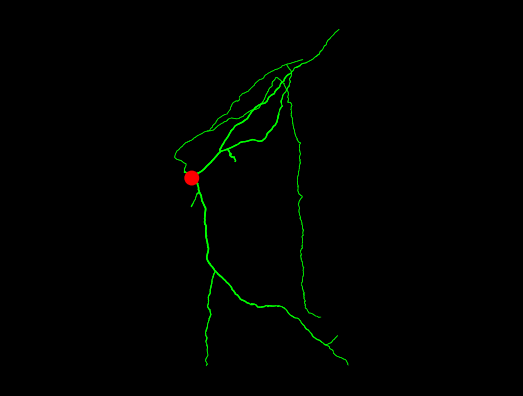
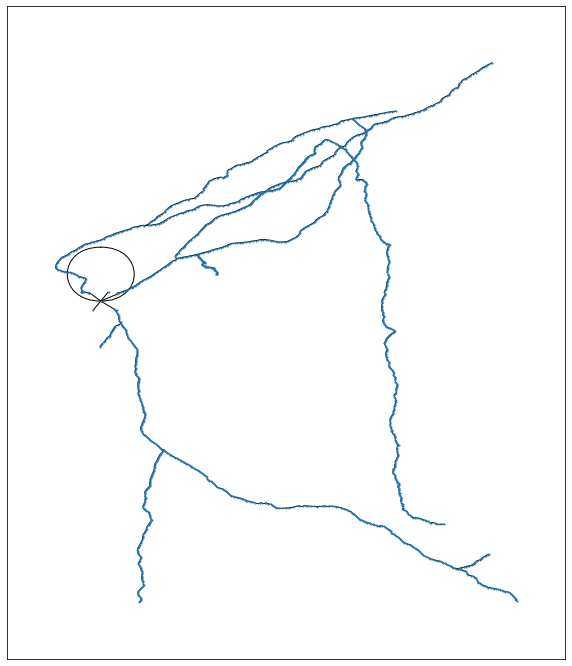

# Criando Imagem do neuronio



### Plot neuronio 1

In [205]:
arquivo = '../dados/swc/mid-neuron.swc'
tab = nd.read_swc(arquivo)
#tab

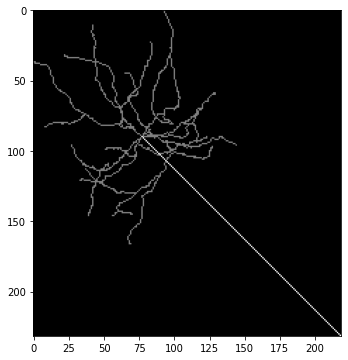

In [206]:
%matplotlib inline

df = nd.create_tab(tab,L=200, theta=-45)
#display(df)
img = nd.create_img(df)
plt.figure(figsize=(12, 6))
plt.imshow(img, cmap='gray')
plt.show()

### Teste de Rotacao 

Tempo para execucao: 0.003965616226196289


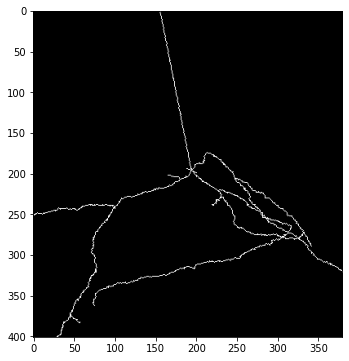

In [8]:
import time

ini = time.time()

df = nd.rot_df(df)
final = time.time()
print(f'Tempo para execucao: {final-ini}')

img = nd.create_img(df)
plt.figure(figsize=(12, 6))
plt.imshow(img, cmap='gray')
plt.show()


# Criando rede de neuronios

### Teste com 10 neurons

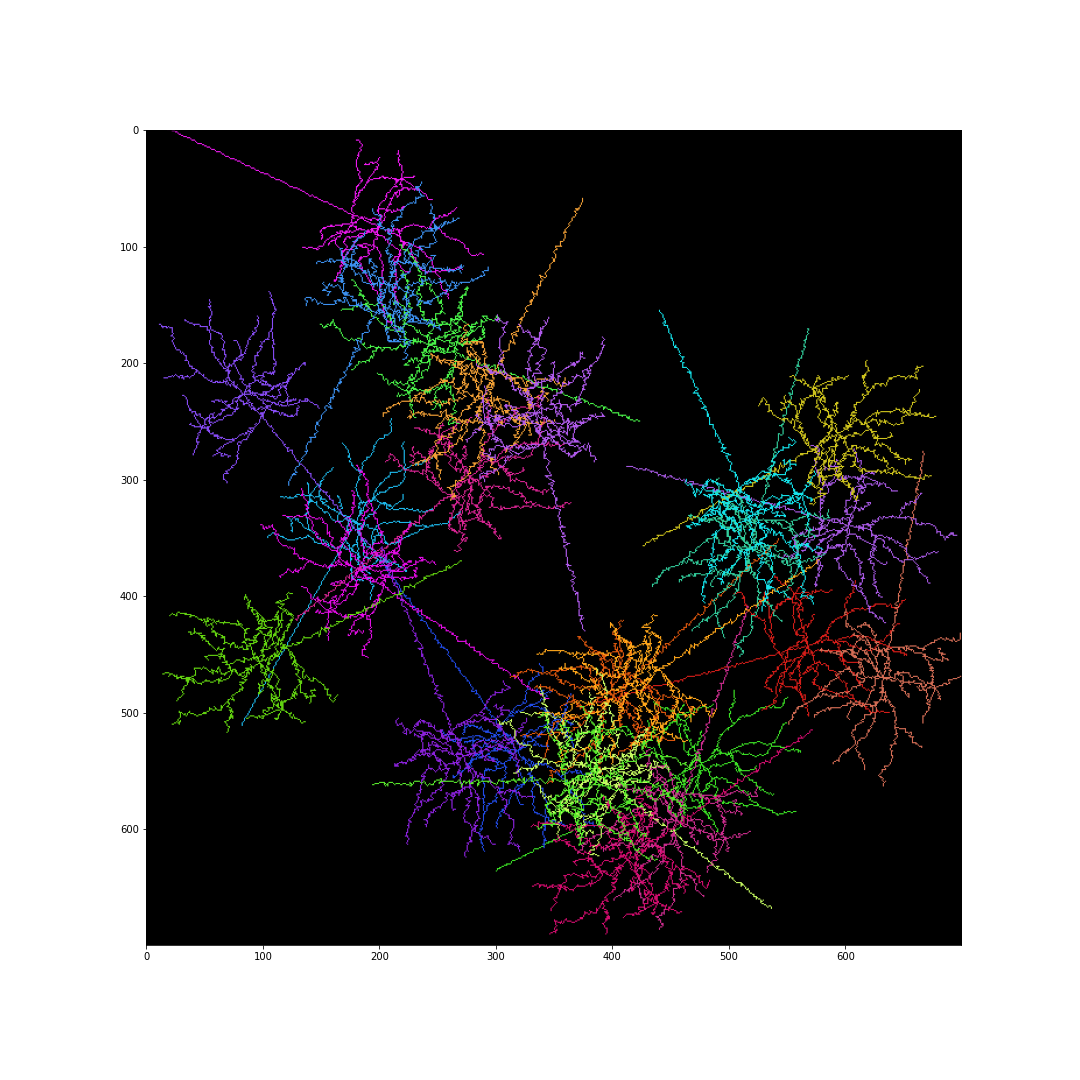

In [208]:
%matplotlib widget
import random 
import time

ini = time.time()
n = 25
seed = 6

df = nd.create_tab(tab, L=200, theta=-45)
random.seed(seed)
np.random.seed(seed)
img_teste, neurons_dict, img_color = nd.create_net(df, n, 700)
#print(neurons_dict)

#plt.figure(figsize=(12, 6))
#plt.imshow(img_teste>0, cmap='gray')

plt.figure(figsize=(15, 15))
plt.imshow(img_color)

plt.show()

#seed 3 
#seed 6 
#seed 45698

In [177]:
for k,v in neurons_dict.items():
    if(len(v)>1):
        print(k, v)

(184, 201) [(0, 1), (2, 1)]
(185, 202) [(0, 1), (2, 1)]
(90, 175) [(1, 1), (2, 1)]
(94, 185) [(1, 1), (2, 1)]
(97, 155) [(1, 1), (2, 1)]
(97, 174) [(1, 1), (2, 1)]
(98, 156) [(1, 1), (2, 1)]
(98, 164) [(1, 1), (2, 1)]
(98, 165) [(1, 1), (2, 1)]
(98, 170) [(1, 1), (2, 1)]
(99, 156) [(1, 1), (2, 1)]
(99, 169) [(1, 1), (2, 1)]
(99, 173) [(1, 1), (2, 1)]
(99, 184) [(1, 1), (2, 1)]
(100, 171) [(1, 1), (2, 1)]
(100, 183) [(1, 1), (2, 1)]
(100, 184) [(1, 1), (2, 1)]
(101, 171) [(1, 1), (2, 1)]
(101, 182) [(1, 1), (2, 1)]
(107, 172) [(1, 1), (2, 1)]
(107, 173) [(1, 1), (2, 1)]
(107, 175) [(1, 1), (2, 1)]
(108, 170) [(1, 1), (2, 1)]
(108, 171) [(1, 1), (2, 1)]
(109, 170) [(1, 1), (2, 1)]
(110, 169) [(1, 1), (2, 1)]
(111, 169) [(1, 1), (2, 1)]
(113, 149) [(1, 1), (2, 1)]
(114, 150) [(1, 1), (2, 1)]
(116, 167) [(1, 1), (2, 1)]
(117, 167) [(1, 1), (2, 1)]
(119, 152) [(1, 2), (2, 1)]
(119, 166) [(1, 1), (2, 1)]
(119, 183) [(1, 2), (2, 1)]
(119, 184) [(1, 1), (2, 1)]
(119, 185) [(1, 2), (2, 1)]
(120

In [204]:
D = nd.create_D(neurons_dict) #Cria a matriz 2xN com os pixels que possuem conexao 
tree = KDTree(D) #Criacao da KD tree para obter os pares proximos com query_pairs()
pairs = tree.query_pairs(r=15, p=2)

edges = nd.create_edges(D, neurons_dict, pairs) #Cria as arestas do grafo

print(edges)

[(0, 1), (0, 1)]


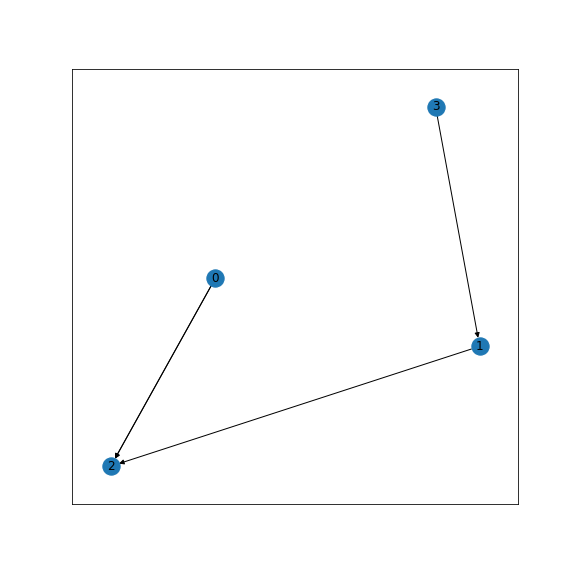

In [119]:
graph1 = nx.MultiDiGraph(edges)

plt.figure(figsize=(8, 8))
nx.draw_networkx(graph1)
#nx.draw_networkx_edges(graph1, {0:(0,0), 1:(0,1)}, connectionstyle='arc3, rad=0.5')
#pos= {0:(0,0), 4:(82,223), 7:(177,336), 5:(183, 381), 2:(310, 512), 3:(396, 491), 6:(480, 545), 8:(557, 442), 9:(602, 339)}
plt.show()

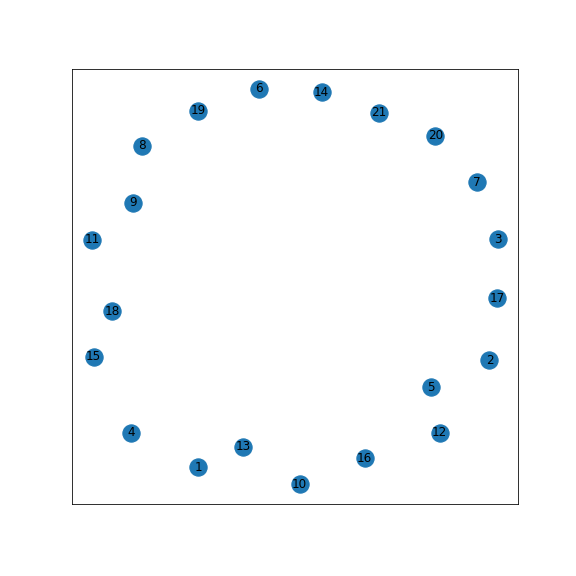

In [44]:
G = nx.MultiDiGraph()

G.add_nodes_from(range(1, 22))
G.add_edges_from([(0, 4), (1, 4), (2,5)]
plt.figure(figsize=(8, 8))
nx.draw_networkx(G)
#nx.draw_networkx_edges(graph1, {0:(0,0), 1:(0,1)}, connectionstyle='arc3, rad=0.5')
plt.show()

In [ ]:
# 10 neuronios

#1 = 93 
#2 = 133 
#3 = 113 
#4 = 94
#5 = 64
#6 = 98
#7 = 43
#8 = 87
#9 = 71
#10 = 70
#11 = 88

#conjunto = [93, 133, 113, 94, 64, 98, 43, 87, 71, 70, 88]
#print(np.mean(conjunto))

# 100 neuronios
# Tempo para execucao com 100 neuronios: 112.47075033187866 segundos
# 4893 conexoes

### Teste com 20 neurons

Tempo para execucao com 20 neuronios: 7.016148090362549


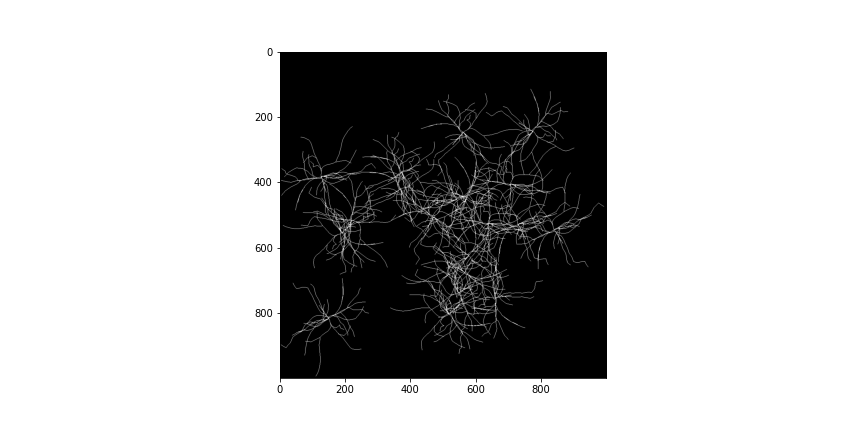

In [20]:
n = 20
ini = time.time()
img_teste, neurons_dict_2 = create_net(df, n, 1000)
final = time.time()
print(f'Tempo para execucao com {n} neuronios: {final-ini}')

plt.figure(figsize=(12, 6))
plt.imshow(img_teste>0, cmap='gray')
plt.show()

TypeError: Invalid shape (1000,) for image data

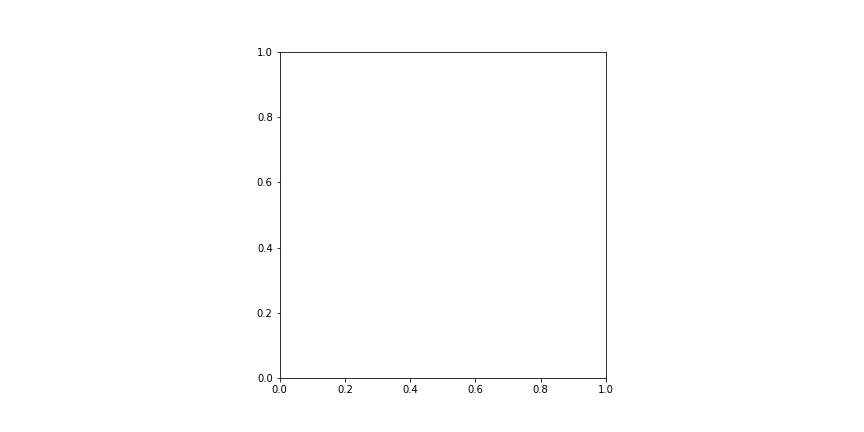

In [21]:
from scipy import ndimage as ndi 
img_teste_dil = ndi.binary_dilation(img_teste[0]>0, iterations=2)
plt.figure(figsize=(12, 6))
plt.imshow(img_teste_dil, cmap='gray')
plt.show()

### Teste com 30 neurons

In [ ]:
n = 30
ini = time.time()
img_teste = create_net(df, n, 2000)
final = time.time()
print(f'Tempo para execucao com {n} neuronios: {final-ini}')

plt.figure(figsize=(12, 6))
plt.imshow(img_teste>0, cmap='gray')
plt.show()

# Tempo para execucao com 10 neuronios: 31.707181453704834
# Tempo para execucao com 20 neuronios: 61.97022986412048
# Tempo para execucao com 30 neuronios: 91.87021279335022

# 2
http://neuromorpho.org/neuron_info.jsp?neuron_name=8-PKCd-3d-trace


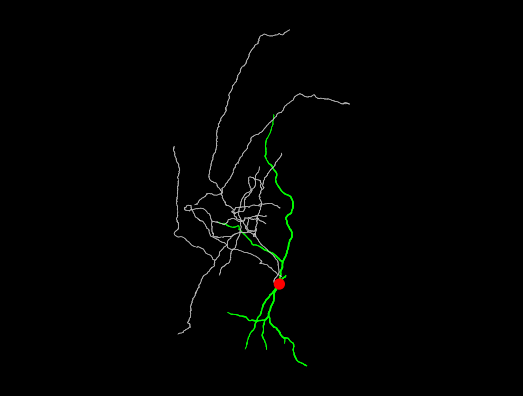

### Plot neuron 2

In [ ]:
#tab_2 = pd.read_excel('Neuronio_2.xlsx')
tab_2 = read_swc('neuron-2.swc')
tab_2

In [ ]:
%matplotlib inline

df_2 = create_tab(tab_2, theta=90)
display(df_2)
img_2 = create_img(df_2)


plt.figure(figsize=(12, 6))
plt.imshow(img_2, cmap='gray')
plt.show()

# TESTE

In [ ]:
rr, cc = line(0, 0, 23, 42)
for i in range(len(rr)):
    print(rr[i], cc[i])

In [25]:
#tabela = '../dados/excel/tabela_1.xlsx'

tab = pd.read_excel('tabela_1.xlsx')


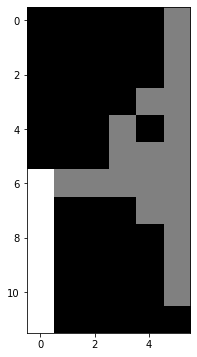

In [26]:
df = nd.create_tab(tab,L=5, theta=270)

img = nd.create_img(df)
plt.figure(figsize=(12, 6))
plt.imshow(img, cmap='gray')
plt.show()


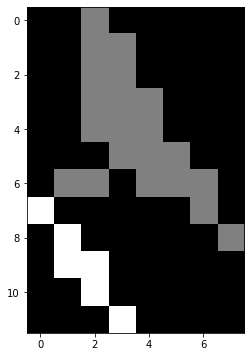

In [27]:
df = nd.rot_df(df)

img = nd.create_img(df)
plt.figure(figsize=(12, 6))
plt.imshow(img, cmap='gray')
plt.show()